In [2]:
# !pip install timeseries-cv
# !pip install pyunlocbox -qqq
# !pip install pygsp -qqq

from graph_learning_algorithm import learn_connected_graph, LapInv
import numpy as np
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet, MultiTaskElasticNetCV, MultiTaskLassoCV, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor
import scipy
from sklearn.covariance import graphical_lasso
from collections import defaultdict
from tsxv.splitTrain import split_train, split_train_variableInput
import itertools
from tqdm.notebook import tqdm
from dask.distributed import Client
import copy
from learn_graph_kalofolias import log_degree_barrier, l2_degree_reg
client = Client(processes=False)
client

Client Scheduler: inproc://192.168.1.13/2408/1 Dashboard: http://192.168.1.13:8787/status,Cluster Workers: 1 Cores: 12 Memory: 15.37 GiB


# Load Data

In [3]:
prices = pd.read_csv("data/prices_CRSP.csv")
prices['datadate'] = prices['datadate'].astype(str).str[:-2]
prices = prices.rename(columns={'datadate': 'year_month'}).set_index('year_month')
prices
# prices['month'] = prices['datadate'].dt.month
# prices['year'] = prices['datadate'].dt.year

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,264647,264686,264708,266214,268208,269005,277812,287462,287882,294524
year_month,,,,,,,,,,,,,,,,,,,,,
196206,59.00,NaN,22.250,NaN,NaN,25.75,NaN,63.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196207,67.48,NaN,21.000,NaN,NaN,28.00,NaN,63.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196208,67.12,NaN,21.750,NaN,NaN,28.75,NaN,58.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196209,63.48,NaN,19.500,NaN,NaN,28.00,NaN,60.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196210,68.00,NaN,18.125,NaN,NaN,26.63,NaN,64.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202206,NaN,NaN,NaN,NaN,14.67,73.12,16.50,108.65,15.34,NaN,...,8.8000,25.31,NaN,63.59,15.12,NaN,11.88,7.28,10.86,87.46
202207,NaN,NaN,NaN,NaN,15.13,73.47,18.42,108.84,16.64,NaN,...,9.3900,27.55,NaN,73.69,16.34,NaN,8.88,7.19,10.74,89.12
202208,NaN,NaN,NaN,NaN,13.99,75.35,18.54,102.65,16.07,NaN,...,9.1300,26.65,NaN,71.38,16.45,NaN,7.77,7.29,10.31,83.00


In [4]:
monthly_log_returns = np.log2(prices).diff().iloc[1:]#.shift(-1).iloc[:-1]
monthly_log_returns

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,264647,264686,264708,266214,268208,269005,277812,287462,287882,294524
year_month,,,,,,,,,,,,,,,,,,,,,
196207,0.193745,NaN,-0.083416,NaN,NaN,0.120854,NaN,-0.005714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196208,-0.007717,NaN,0.050626,NaN,NaN,0.038135,NaN,-0.119299,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196209,-0.080441,NaN,-0.157541,NaN,NaN,-0.038135,NaN,0.054908,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196210,0.099233,NaN,-0.105493,NaN,NaN,-0.072374,NaN,0.103919,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196211,0.099986,NaN,0.212408,NaN,NaN,0.178148,NaN,0.107313,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202206,NaN,NaN,NaN,NaN,-0.318186,-0.086720,-0.823008,-0.112481,-0.114754,NaN,...,-0.218711,-0.138488,NaN,-0.261180,-0.143390,NaN,-0.116598,0.017947,-0.637999,-0.385499
202207,NaN,NaN,NaN,NaN,0.044543,0.006889,0.158807,0.002521,0.117357,NaN,...,0.093622,0.122345,NaN,0.212669,0.111950,NaN,-0.419903,-0.017947,-0.016030,0.027126
202208,NaN,NaN,NaN,NaN,-0.113016,0.036452,0.009368,-0.084475,-0.050286,NaN,...,-0.040510,-0.047917,NaN,-0.045949,0.009680,NaN,-0.192645,0.019927,-0.058950,-0.102638


# Load the factors and evaluate residuals

In [5]:
factors = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors = factors.set_index('Date')
factors.columns += '_factor'
factors = factors.astype(np.float64)
factors

,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
Date,,,,,,
196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
202205,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,9.57,1.88,-4.10,0.68,-6.94,0.08


In [6]:
returns_factors_merged = monthly_log_returns.merge(factors, right_index=True, left_index=True, suffixes=['', '_factor'])
returns_factors_merged

,1010,1034,1040,1054,1062,1075,1076,1078,1119,1128,...,277812,287462,287882,294524,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
196307,-0.068842,NaN,-0.205810,NaN,NaN,0.023847,NaN,0.200299,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,0.141354,NaN,0.065434,NaN,NaN,0.130175,NaN,0.145978,NaN,NaN,...,NaN,NaN,NaN,NaN,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.102568,NaN,-0.114742,NaN,NaN,-0.043881,NaN,-0.032105,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,0.080909,NaN,-0.020043,NaN,NaN,-0.080158,NaN,-0.087401,NaN,NaN,...,NaN,NaN,NaN,NaN,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,0.309237,NaN,0.020043,NaN,NaN,0.040406,NaN,0.067263,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202205,NaN,NaN,NaN,NaN,-0.168785,0.125109,0.141116,0.049477,-0.017268,NaN,...,0.263483,-0.403454,0.058360,0.107722,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,NaN,NaN,NaN,NaN,-0.318186,-0.086720,-0.823008,-0.112481,-0.114754,NaN,...,-0.116598,0.017947,-0.637999,-0.385499,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,NaN,NaN,NaN,NaN,0.044543,0.006889,0.158807,0.002521,0.117357,NaN,...,-0.419903,-0.017947,-0.016030,0.027126,9.57,1.88,-4.10,0.68,-6.94,0.08
202208,NaN,NaN,NaN,NaN,-0.113016,0.036452,0.009368,-0.084475,-0.050286,NaN,...,-0.192645,0.019927,-0.058950,-0.102638,-3.78,1.51,0.31,-4.80,1.31,0.19


# Cross Validation

In [7]:
X, y = split_train(returns_factors_merged.index.values, numInputs=24, numOutputs=12, numJumps=1)

In [8]:
returns_factors_merged_split_train = returns_factors_merged.loc[X[0]]
returns_factors_merged_split_test = returns_factors_merged.loc[y[0]]

factors_split_train = returns_factors_merged_split_train[factors.columns]
returns_split_train = returns_factors_merged_split_train.drop(columns=factors.columns)

factors_split_test = returns_factors_merged_split_test[factors.columns]
returns_split_test = returns_factors_merged_split_test.drop(columns=factors.columns)

not_na_columns = ~returns_split_train.isna().any(axis=0)
returns_split_train = returns_split_train.loc[:, not_na_columns]
returns_split_test = returns_split_test.loc[:, not_na_columns]
returns_split_train.head()

,1010,1040,1075,1078,1157,1209,1215,1221,1243,1279,...,11550,11555,11559,11609,12564,13499,14331,15106,28590,30865
196307,-0.068842,-0.205810,0.023847,0.200299,-0.114430,-0.027193,-0.023274,-0.010344,-0.107211,0.000000,...,-0.036366,0.036158,-0.004578,0.047668,0.005588,-0.050465,0.084392,-0.185024,-0.100328,-0.083636
196308,0.141354,0.065434,0.130175,0.145978,-0.010244,0.111484,0.092461,-0.015258,0.000000,0.170429,...,0.048287,0.012065,0.069925,-0.036527,0.021292,0.171480,0.205904,0.082501,0.028592,0.049101
196309,-1.102568,-0.114742,-0.043881,-0.032105,-0.045251,-0.054665,-0.038903,0.010457,0.093405,-0.167030,...,0.000000,-0.064662,-0.004923,0.011055,-0.026879,-0.121015,-0.065423,-0.175544,-0.123989,-0.006680
196310,0.080909,-0.020043,-0.080158,-0.087401,-0.070209,-0.078326,0.048086,0.260360,-0.028014,0.055495,...,-0.085594,0.044605,-0.050740,0.025472,-0.021695,0.057450,0.072512,0.029040,0.060373,-0.007260
196311,0.309237,0.020043,0.040406,0.067263,-0.024788,0.078326,-0.018939,0.025203,-0.043069,-0.062300,...,-0.045040,-0.024248,0.139459,-0.032833,-0.049814,-0.084758,-0.072512,0.115477,-0.011898,-0.049586


### Find the best parameter for the lasso regression

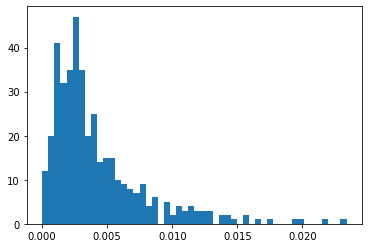

Median alpha: 3.064236e-03, Mean alpha: 4.211538e-03


In [9]:
alphas = [LassoLarsIC(fit_intercept=True).fit(factors_split_train, returns_split_train[col]).alpha_ for col in returns_split_train.columns]
plt.hist(alphas, bins=50)
plt.show()
print(f'Median alpha: {np.median(alphas):e}, Mean alpha: {np.mean(alphas):e}')

In [10]:
factor_model = ElasticNet(3e-3, fit_intercept=True).fit(factors_split_train, returns_split_train)
# factor_model = Lasso(3e-3, fit_intercept=False).fit(factors_split_train, returns_split_train)
# factor_model = LinearRegression(fit_intercept=False).fit(factors_split_train, returns_split_train)

In [11]:
train_residuals = returns_split_train - factor_model.predict(factors_split_train)
test_residuals = returns_split_test - factor_model.predict(factors_split_test)
(factor_model.coef_ != 0).mean()

0.7788778877887789

In [12]:
def compute_factor_residuals(X_train, factors_train, X_test=None, factors_test=None, alpha_elastic_net=3e-3):
    factor_model = ElasticNet(alpha = alpha_elastic_net, fit_intercept = False).fit(factors_train, X_train)
    train_residuals = X_train - factor_model.predict(factors_train)
    if (X_test is None) or (factors_test is None):
        return train_residuals
    test_residuals  = X_test  - factor_model.predict(factors_test)
    return train_residuals, test_residuals

In [136]:
def quantiles_std_trading_rule(q, w, gamma, trading_type):
    def q_std_traing(train_spreads, test_spreads):
        _q = q
        rolling_spreads = pd.concat([train_spreads, test_spreads]).rolling(w, min_periods=1).mean()
        train_rolling_spreads = rolling_spreads.loc[train_spreads.index]
        test_rolling_spreads = rolling_spreads.loc[test_spreads.index]

        if trading_type == 'both':
            _q /= 2
        lower, upper = np.quantile(test_rolling_spreads, 
                                   (_q, 1-_q), axis=1).reshape((2, -1, 1))

        trading_mask = np.zeros_like(test_rolling_spreads)
        
        if (trading_type == 'short') or (trading_type == 'both'):
            q_mask = (test_rolling_spreads >= upper) | (q == 1)
            # print(f'Short\nq:{q}, q_mask:\n{q_mask}')
            # print(f'q_mask row sum:\n{q_mask.sum(axis=1)}')
            std_mask = (test_spreads - test_rolling_spreads >= gamma * train_rolling_spreads.std()) | (gamma == 0)
            # print(f'gamma:{gamma}, std_mask:\n{std_mask}')
            short_mask = q_mask & std_mask
            short_mask /= short_mask.sum(axis=1).values.reshape((-1, 1))
            short_mask = short_mask.fillna(0)
            trading_mask = trading_mask - short_mask

        if (trading_type == 'long') or (trading_type == 'both'):
            q_mask = (test_rolling_spreads <= lower) | (q == 1)
            # print(f'Long\nq:{q}, q_mask:\n{q_mask}')
            # print(f'q_mask row sum:\n{q_mask.sum(axis=1)}')
            std_mask = (test_spreads - test_rolling_spreads <= -gamma * train_rolling_spreads.std()) | (gamma == 0)
            # print(f'gamma:{gamma}, std_mask:\n{std_mask}')
            long_mask = q_mask & std_mask
            long_mask /= long_mask.sum(axis=1).values.reshape((-1, 1))
            long_mask = long_mask.fillna(0)
            trading_mask = trading_mask + long_mask
        
        return trading_mask
    
    return q_std_traing

In [137]:
def compute_identity_L():
    def L_identity(X_train):
        L = np.eye(X_train.shape[1])
        L_sqrt = L
        return L, L_sqrt
    return L_identity

def compute_corr_L(k, use_abs=True):
    def L_corr(X_train):
        p = X_train.shape[1]
        S = np.corrcoef(X_train, rowvar=False)
        
        if use_abs:
            S_sign = np.sign(S)
            S *= S_sign
            
        L = np.eye(p)
        L[np.hstack([np.arange(p).reshape((-1, 1))] * k), 
          np.argsort(S)[:, -(k+1):-1]] = -1/k
        
        if use_abs:
            L *= S_sign
            
        L_sqrt = L
        return L, L_sqrt
    return L_corr
    
def compute_SGS_L(alpha=1, beta=1, laplacian_root=True, 
                  adjust_laplacian=True, threshold=1e-5, normalize=True):
    def L_SGS(X_train):
        if normalize:
            X_train = X_train / (X_train**2).sum()
        A = log_degree_barrier(X_train.T, alpha=alpha, beta=alpha)
        A *= A > threshold
        L = np.diag(A.sum(axis=0)) - A
        L_sqrt = L

        if laplacian_root:
            lambdas, V = np.linalg.eigh(L)
            L_sqrt = V @ np.diag(np.sqrt(np.fmax(0, lambdas))) @ V.T
            
        if adjust_laplacian:
            A_sqrt = np.diag(np.diag(L_sqrt)) - L_sqrt
            X_train_pred = X_train @ A_sqrt
            beta = (X_train * X_train_pred).sum(axis=0) / (X_train ** 2).sum(axis=0)
            L_sqrt = (np.diag(1/beta) - A_sqrt)
        return L, L_sqrt
    return L_SGS

def compute_LGMRF_L(use_correlations=True, use_abs=True, reltol=3e-4,
                    laplacian_root=True, adjust_laplacian=True):
    def L_LGMRF(X_train):
        S = X_train.T @ X_train
        if use_correlations:
            prec = np.diag(1 / np.sqrt(np.diag(S)))
            S = (prec @ S @ prec)
        if use_abs:
            S_sign = np.sign(S)
            S *= S_sign
    
        results_LGMRF = learn_connected_graph(S, verbose=False, rho=1, 
                                              reltol = reltol, maxiter=1000)
        L = results_LGMRF['L']
        L_sqrt = L

        if laplacian_root:
            lambdas, V = np.linalg.eigh(L)
            L_sqrt = V @ np.diag(np.sqrt(np.fmax(0, lambdas))) @ V.T

        if use_abs:
            L *= S_sign
            L_sqrt *= S_sign
            
        if adjust_laplacian:
            A_sqrt = np.diag(np.diag(L_sqrt)) - L_sqrt
            X_train_pred = X_train @ A_sqrt
            beta = (X_train * X_train_pred).sum(axis=0) / (X_train ** 2).sum(axis=0)
            L_sqrt = (np.diag(1/beta) - A_sqrt)
        return L, L_sqrt
    return L_LGMRF


def compute_spreads(X_train, X_test, method, fit_intercept=False):
    train_returns = X_train.values
    test_returns = X_test.values
    
    if fit_intercept:
        train_returns = np.hstack([train_returns, np.ones((train_returns.shape[0], 1))])
        test_returns = np.hstack([test_returns, np.ones((test_returns.shape[0], 1))])
    
    L, L_sqrt = method(train_returns)
    
    spreads_train = train_returns @ L_sqrt
    spreads_test = test_returns @ L_sqrt
    
    if fit_intercept:
        spreads_train = spreads_train[:, :-1]
        spreads_test = spreads_test[:, :-1]
    
    return (pd.DataFrame(spreads_train, index=X_train.index, columns=X_train.columns),
           pd.DataFrame(spreads_test, index=X_test.index, columns=X_test.columns),
           L, L_sqrt)

In [153]:
def compute_config_returns(train_spreads, test_spreads, returns_fwd, trading_method, L_sqrt, 
                           columns_trading_mask=None, benchmark=True):
    trading_mask = trading_method(train_spreads, test_spreads)
    # print('Number of open positions on average:', np.abs(trading_mask != 0).sum(axis=1).mean())
    
    A_sqrt = np.diag(np.diag(L_sqrt)) - L_sqrt
    row_sum = A_sqrt.sum(axis=1, keepdims=True)
    row_sum += np.abs(row_sum) < 1e-6 
    A_sqrt = A_sqrt / row_sum
    compl_trading_mask = - trading_mask @ A_sqrt
    compl_trading_mask.columns = trading_mask.columns
    
    full_trading_returns = returns_fwd * trading_mask
    compl_full_trading_returns = returns_fwd * compl_trading_mask
    
    if columns_trading_mask is not None:
        full_trading_returns = full_trading_returns.loc[:, columns_trading_mask]
        compl_full_trading_returns = compl_full_trading_returns.loc[:, columns_trading_mask]
    # print('full_trading_returns')
    # print(full_trading_returns.head())
    # print('compl_full_trading_returns')
    # print(compl_full_trading_returns.head())
    
    trading_returns = full_trading_returns.sum(axis=1)
    compl_trading_returns = compl_full_trading_returns.sum(axis=1)
    
    trading_returns_df = pd.DataFrame({'avg_month_returns': trading_returns,
                                       'compl_avg_month_returns': compl_trading_returns,
                                       'pairs_avg_month_returns': (trading_returns + compl_trading_returns) / 2,
                                      }).reset_index()
    
    if not benchmark:
        return trading_returns_df
    
    trading_returns_df['benchmark'] = False
    
    full_benchmark_returns = returns_fwd
    
    if columns_trading_mask is not None:
        full_benchmark_returns = full_benchmark_returns.loc[:, columns_trading_mask]
        
    benchmark_returns = full_benchmark_returns.mean(axis=1)
    
    benchmark_returns_df = pd.DataFrame({'avg_month_returns': benchmark_returns,
                                         'compl_avg_month_returns': benchmark_returns,
                                         'pairs_avg_month_returns': benchmark_returns,
                                         'benchmark': True
                                        }).reset_index()
    return pd.concat([trading_returns_df, benchmark_returns_df])

In [154]:
def evaluate_split_returns(train_returns, test_returns, residuals_methods, spreads_methods, trading_methods):
    l = []
    test_returns_fwd = test_returns.shift(-1).iloc[:-1]
    print(f'train_returns shape: {train_returns.shape}')
    for res_name, res_func in residuals_methods.items():
        X_train, X_test = res_func(train_returns, test_returns)
        l1 = []
        for spreads_name, spreads_func in spreads_methods.items():
            # spreads_train, spreads_test, L, L_sqrt = spreads_func(X_train, X_test)
            print(f'Inizio compute spreads: {spreads_name}')
            
            spreads_train, spreads_test, L, L_sqrt = compute_spreads(X_train, X_test, spreads_func)
            spreads_test = spreads_test.iloc[:-1]
            
            print(f'Fine compute spreads: {spreads_name}')
            
            l2 = []
            for trading_name, trading_func in trading_methods.items():
                trading_results = compute_config_returns(spreads_train, spreads_test, test_returns_fwd, 
                                                         trading_func, L_sqrt)
                trading_results['trading_method'] = trading_name
                l2.append(trading_results)
            df2 = pd.concat(l2)
            df2['spreads_method'] = spreads_name
            l1.append(df2)
        df1 = pd.concat(l1)
        df1['residuals_method'] = res_name
        l.append(df1)
    return pd.concat(l)

In [155]:
def evaluate_split_returns_from_idx(merged_df, factors_columns, idx_tuple):
    x_idx, y_idx = idx_tuple
    returns_factors_merged_split_train = merged_df.loc[x_idx]
    returns_factors_merged_split_test = merged_df.loc[y_idx]
    # Extract factor columns
    factors_train = returns_factors_merged_split_train[factors_columns]
    factors_test = returns_factors_merged_split_test[factors_columns]
    # Extract return column 
    returns_split_train = returns_factors_merged_split_train.drop(columns=factors_columns)
    returns_split_test = returns_factors_merged_split_test.drop(columns=factors.columns)
    # Remove NaN from return columns
    not_na_columns = ~returns_split_train.isna().any(axis=0)
    not_na_columns &= ~returns_split_test.isna().any(axis=0)
    train_returns = returns_split_train.loc[:, not_na_columns]
    test_returns = returns_split_test.loc[:, not_na_columns]
    
    # Define residuals, spreads and trading methods
    residuals_methods = {
        'returns': (lambda train, test: (train, test)),                 
        'residuals': (lambda train, test: compute_factor_residuals(train, factors_train, test, factors_test))
    }
    spreads_methods = {
        # Identity
        'Identity': compute_identity_L(),
        # Top-k correlations
        # 'Corr-1': compute_corr_L(1),
        'Corr-5': compute_corr_L(5),
        'Corr-20': compute_corr_L(20),
        'Corr-50': compute_corr_L(50),
        # Smooth graph signals
        'SGS laplacian_root=True, adjust_laplacian=True': compute_SGS_L(laplacian_root=True, adjust_laplacian=True),
        # 'SGS laplacian_root=True, adjust_laplacian=False': compute_SGS_L(laplacian_root=True, adjust_laplacian=False),
        # 'SGS laplacian_root=False, adjust_laplacian=True': compute_SGS_L(laplacian_root=False, adjust_laplacian=True),
        # 'SGS laplacian_root=False, adjust_laplacian=False': compute_SGS_L(laplacian_root=False, adjust_laplacian=False),
        # Laplacian constrained gaussian markov random field
        'LGMRF laplacian_root=True, adjust_laplacian=True': compute_LGMRF_L(laplacian_root=True, adjust_laplacian=True),
        # 'LGMRF laplacian_root=True, adjust_laplacian=False': compute_LGMRF_L(laplacian_root=True, adjust_laplacian=False),
        # 'LGMRF laplacian_root=False, adjust_laplacian=True': compute_LGMRF_L(laplacian_root=False, adjust_laplacian=True),
        # 'LGMRF laplacian_root=False, adjust_laplacian=False': compute_LGMRF_L(laplacian_root=False, adjust_laplacian=False),
    }
    
    windows = [1, 2, 4, 12, 24]
    # windows = [2]
    # quantiles = [.5, 1]
    quantiles = [.2, .5, 1]
    gammas = [0, 2]
    trading_type = ['long', 'short', 'both']
    trading_methods = {f'Quantile-std w={_w} q={_q} gamma={_g} {_t_type}': quantiles_std_trading_rule(q=_q, w=_w, trading_type=_t_type, gamma=_g)
                        for _w, _q, _g, _t_type in itertools.product(windows, quantiles, gammas, trading_type) if not((_g==0) & (_q == 1))}
    return evaluate_split_returns(train_returns, test_returns, residuals_methods, spreads_methods, trading_methods)

In [4]:
'returns residuals'.split()

['returns', 'residuals']

In [156]:
X, y = split_train(returns_factors_merged.index.values, numInputs=50, numOutputs=12+1, numJumps=1)
futures = client.map(lambda idx: evaluate_split_returns_from_idx(returns_factors_merged, factors.columns, idx_tuple=idx), 
                     list(zip(X, y))[::12][-12:])
results = client.gather(futures)

train_returns shape: (50, 1382)train_returns shape: (50, 1404)
Inizio compute spreads: Identity

Inizio compute spreads: Identity
Fine compute spreads: Identity
train_returns shape: (50, 1405)
Inizio compute spreads: Identity
Fine compute spreads: Identity
Fine compute spreads: Identity
train_returns shape: (50, 1413)
Inizio compute spreads: Identity
Fine compute spreads: Identity
train_returns shape: (50, 1416)
Inizio compute spreads: Identity
train_returns shape: (50, 1420)
Inizio compute spreads: Identity
Fine compute spreads: Identity
train_returns shape: (50, 1318)
Fine compute spreads: Identitytrain_returns shape: (50, 1281)Inizio compute spreads: Identity


Inizio compute spreads: Identity
train_returns shape: (50, 1392)Fine compute spreads: Identity

train_returns shape: (50, 1347)
Inizio compute spreads: Identity
Fine compute spreads: IdentityInizio compute spreads: Identity
train_returns shape: (50, 1403)

Inizio compute spreads: Identity
train_returns shape: (50, 1239)
Inizi

Inizio compute spreads: SGS laplacian_root=True, adjust_laplacian=True
Inizio compute spreads: Identity
Fine compute spreads: Identity
Fine compute spreads: SGS laplacian_root=True, adjust_laplacian=True
Inizio compute spreads: Identity
Fine compute spreads: Identity
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: LGMRF laplacian_root=True, adjust_laplacian=True
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: LGMRF laplacian_root=True, adjust_laplacian=True
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: LGMRF laplacian_root=True, adjust_laplacian=True
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: Corr-5
Fine compute spreads: Corr-5
Inizio compute spreads: Corr-5
Fi

In [157]:
split_returns_df = pd.concat(results)
# split_returns_df['compl_avg_month_returns'] = np.real(split_returns_df['compl_avg_month_returns'])
# split_returns_df['pairs_avg_month_returns'] = np.real(split_returns_df['pairs_avg_month_returns'])
split_returns_df['config'] = split_returns_df['residuals_method'] + ' - '+ split_returns_df['spreads_method'] + ' - ' + split_returns_df['trading_method']
split_returns_df['residuals_method_name'] = split_returns_df['residuals_method'].str.split(expand=True)[0]
split_returns_df['trading_method_name'] = split_returns_df['trading_method'].str.split(expand=True)[0]
split_returns_df['spreads_method_name'] = split_returns_df['spreads_method'].str.split(expand=True)[0]
split_returns_df['date'] = pd.to_datetime(split_returns_df['index'].str[:4] + '-' + split_returns_df['index'].str[4:] + '-01')
split_returns_df

,index,avg_month_returns,compl_avg_month_returns,pairs_avg_month_returns,benchmark,trading_method,spreads_method,residuals_method,config,residuals_method_name,trading_method_name,spreads_method_name,date
0,201009,0.015436,0.000000,0.007718,False,Quantile-std w=1 q=0.2 gamma=0 long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2010-09-01
1,201010,0.001958,0.000000,0.000979,False,Quantile-std w=1 q=0.2 gamma=0 long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2010-10-01
2,201011,0.050955,0.000000,0.025478,False,Quantile-std w=1 q=0.2 gamma=0 long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2010-11-01
3,201012,-0.015112,0.000000,-0.007556,False,Quantile-std w=1 q=0.2 gamma=0 long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2010-12-01
4,201101,0.043883,0.000000,0.021941,False,Quantile-std w=1 q=0.2 gamma=0 long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,202204,0.013164,0.013164,0.013164,True,Quantile-std w=24 q=1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=True",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-04-01
8,202205,-0.134348,-0.134348,-0.134348,True,Quantile-std w=24 q=1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=True",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-05-01
9,202206,0.097985,0.097985,0.097985,True,Quantile-std w=24 q=1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=True",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-06-01
10,202207,-0.056156,-0.056156,-0.056156,True,Quantile-std w=24 q=1 gamma=2 both,"LGMRF laplacian_root=True, adjust_laplacian=True",residuals,"residuals - LGMRF laplacian_root=True, adjust_...",residuals,Quantile-std,LGMRF,2022-07-01


In [158]:
# split_returns_df.to_pickle('data/results_CRSP.pkl')

In [159]:
trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='avg_month_returns', columns='config', index='index')
# trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='compl_avg_month_returns', columns='config', index='index')
# trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='pairs_avg_month_returns', columns='config', index='index')
trading_returns *= np.sign(trading_returns.mean())
trading_returns
trading_returns.index = factors.loc[trading_returns.index[1]:].iloc[:len(trading_returns)].index
K = 5
top_mean_configs = trading_returns.mean().sort_values(ascending=False).iloc[:K].index.values
top_sharpe_configs = (trading_returns.mean() / trading_returns.std()).sort_values(ascending=False).iloc[:K].index.values

trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
trading_alphas = pd.Series(trading_returns_lm.intercept_, index=trading_returns.columns, name='alpha').sort_values(ascending=False)
top_alpha_configs = trading_alphas.iloc[:K].index.values
top_configs = set(top_mean_configs.tolist() + top_sharpe_configs.tolist() + top_alpha_configs.tolist())

In [160]:
trading_returns_mean = trading_returns.mean().reset_index()
#trading_returns_mean = (trading_returns.mean() / trading_returns.std()).fillna(0).reset_index()
# trading_returns_mean = trading_alphas.reset_index().rename(columns={'alpha': 0})
trading_returns_mean[['data', 'graph', 'trading']] = trading_returns_mean['config'].str.split(' - ', expand=True)
trading_returns_mean[['trading', 'w', 'q', 'gamma', 'type']] = trading_returns_mean['trading'].str.split(' ', expand=True)
trading_returns_mean['w'] = trading_returns_mean['w'].str.split('=', expand=True)[1].astype(int)
trading_returns_mean['q'] = trading_returns_mean['q'].str.split('=', expand=True)[1].astype(float)
trading_returns_mean['gamma'] = trading_returns_mean['gamma'].str.split('=', expand=True)[1].astype(float)
trading_returns_mean['data'] = trading_returns_mean['data'].map(dict(zip(trading_returns_mean['data'].unique(), 
                                                                         range(trading_returns_mean['data'].nunique()))))
trading_returns_mean['graph'] = trading_returns_mean['graph'].map(dict(zip(trading_returns_mean['graph'].unique(), 
                                                                         range(trading_returns_mean['graph'].nunique()))))
trading_returns_mean['type'] = trading_returns_mean['type'].map(dict(zip(trading_returns_mean['type'].unique(), 
                                                                         range(trading_returns_mean['type'].nunique()))))
trading_returns_mean = trading_returns_mean.drop(columns=['config', 'trading']).rename(columns={0: 'mean'})
trading_returns_mean

,mean,data,graph,w,q,gamma,type
0,0.010175,0,0,1,0.2,0.0,0
1,0.008588,0,0,1,0.2,0.0,1
2,0.000392,0,0,1,0.2,0.0,2
3,0.000000,0,0,1,0.2,2.0,0
4,0.000000,0,0,1,0.2,2.0,1
...,...,...,...,...,...,...,...
895,0.004055,1,5,4,0.5,2.0,1
896,0.004878,1,5,4,0.5,2.0,2
897,0.001962,1,5,4,1.0,2.0,0
898,0.001200,1,5,4,1.0,2.0,1


(0.9749560962240841, 1.0)

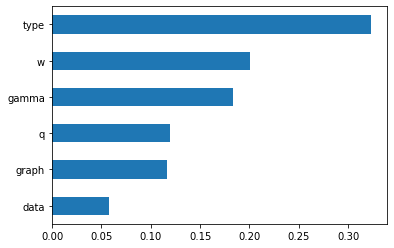

In [161]:
rf = RandomForestRegressor().fit(trading_returns_mean.iloc[:, 1:], trading_returns_mean.iloc[:, 0])
pd.Series(rf.feature_importances_, index=trading_returns_mean.iloc[:, 1:].columns).sort_values().plot.barh()
rf.score(trading_returns_mean.iloc[:, 1:], trading_returns_mean.iloc[:, 0]), rf.feature_importances_.sum()

In [162]:
# trading_alphas
# trading_returns
trading_returns.mean().sort_values(ascending=False).head()

config
returns - SGS laplacian_root=True, adjust_laplacian=True - Quantile-std w=2 q=0.5 gamma=2 both       0.036320
returns - Identity - Quantile-std w=2 q=0.2 gamma=2 both                                             0.029883
returns - Identity - Quantile-std w=2 q=0.5 gamma=2 both                                             0.026213
returns - LGMRF laplacian_root=True, adjust_laplacian=True - Quantile-std w=2 q=0.5 gamma=2 both     0.020456
returns - LGMRF laplacian_root=True, adjust_laplacian=True - Quantile-std w=24 q=0.2 gamma=2 both    0.020050
dtype: float64

In [163]:
trading_alphas_mean = trading_alphas.reset_index().set_index('config').copy()
trading_alphas_mean['mean'] = trading_returns.mean()
2 ** (trading_alphas_mean.sort_values('alpha', ascending=False).head(7) * 12) - 1
# trading_alphas_mean.sort_values('alpha', ascending=False).head(7)

,alpha,mean
config,,
"returns - SGS laplacian_root=True, adjust_laplacian=True - Quantile-std w=4 q=0.2 gamma=2 long",0.301271,0.041610
"returns - SGS laplacian_root=True, adjust_laplacian=True - Quantile-std w=4 q=0.5 gamma=2 long",0.289024,0.034300
"returns - SGS laplacian_root=True, adjust_laplacian=True - Quantile-std w=4 q=1 gamma=2 long",0.248554,0.010034
"returns - SGS laplacian_root=True, adjust_laplacian=True - Quantile-std w=12 q=0.2 gamma=2 long",0.216102,0.004874
returns - Identity - Quantile-std w=2 q=0.2 gamma=2 short,0.215846,0.164623
"returns - SGS laplacian_root=True, adjust_laplacian=True - Quantile-std w=24 q=0.2 gamma=2 short",0.191072,0.065586
"returns - SGS laplacian_root=True, adjust_laplacian=True - Quantile-std w=24 q=0.5 gamma=2 short",0.165934,0.044190


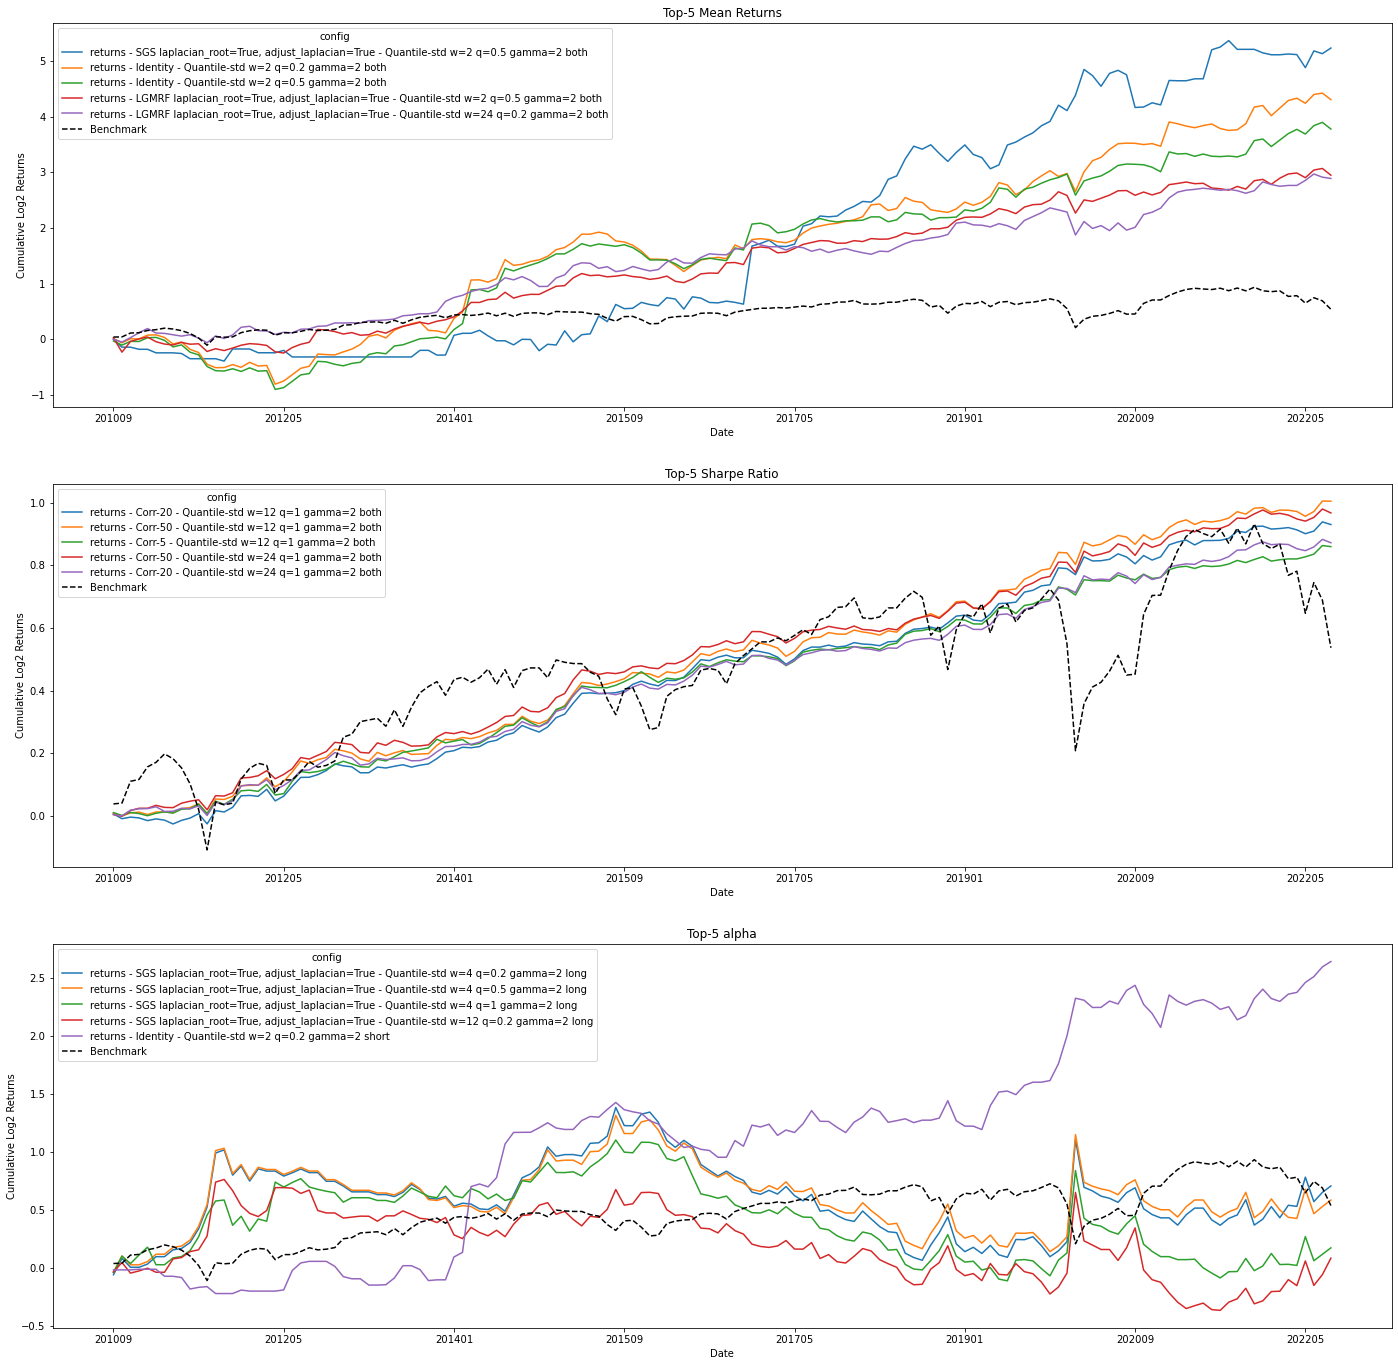

In [164]:
fig, axs =plt.subplots(3, figsize=(24, 24))
trading_returns[top_mean_configs].cumsum().plot(ax=axs[0])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Cumulative Log2 Returns')
axs[0].set_title('Top-5 Mean Returns')
trading_returns[top_sharpe_configs].cumsum().plot(ax=axs[1])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Cumulative Log2 Returns')
axs[1].set_title('Top-5 Sharpe Ratio')
trading_returns[top_alpha_configs].cumsum().plot(ax=axs[2])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[2])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Cumulative Log2 Returns')
axs[2].set_title('Top-5 alpha')
plt.show()

In [165]:
idx_alpha, _ = split_train(trading_returns.index.values, numInputs=24, numOutputs=0, numJumps=1)
intercepts = []
for idx in idx_alpha:
    intercepts.append(LinearRegression(fit_intercept=True).fit(factors.loc[idx], trading_returns.loc[idx]).intercept_)

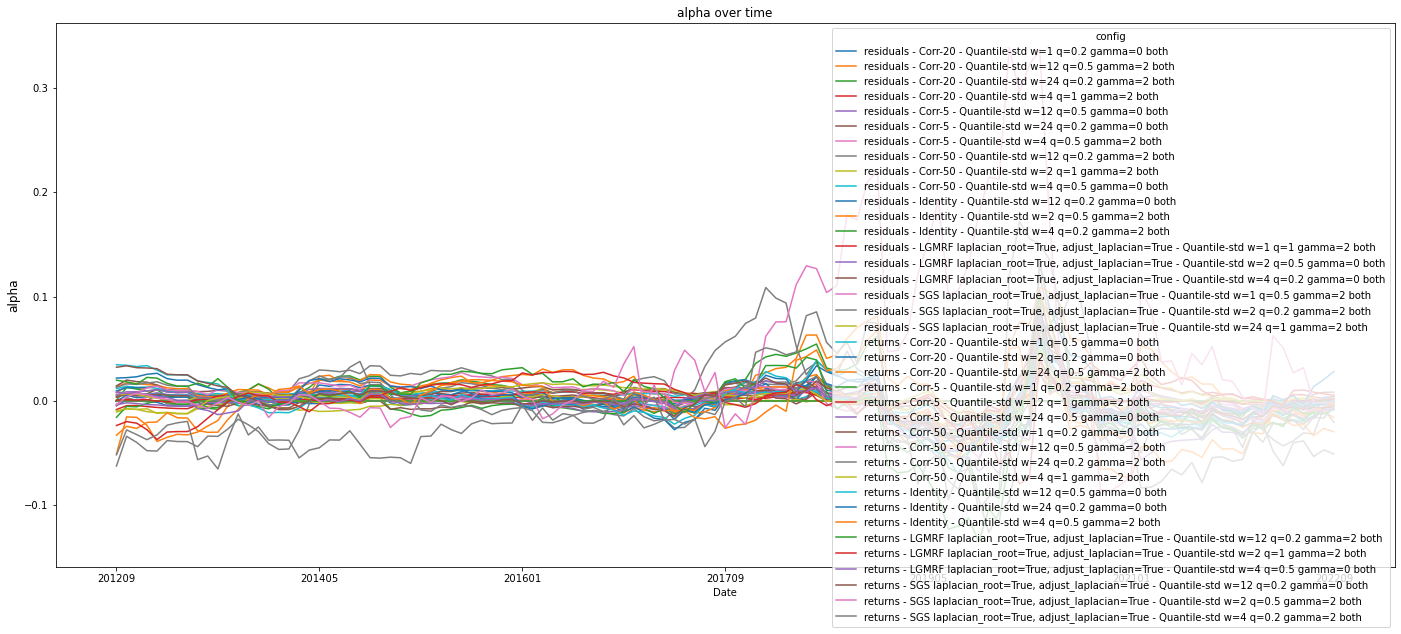

In [166]:
fig, ax =plt.subplots(figsize=(24, 10))
alpha_df = pd.DataFrame(np.array(intercepts), index=trading_returns.index[23:], columns=trading_returns.columns)
alpha_df.iloc[:, ::24].plot(ax=ax)
ax.set_title('alpha over time')
ax.set_ylabel('alpha', fontsize=12)
plt.show()

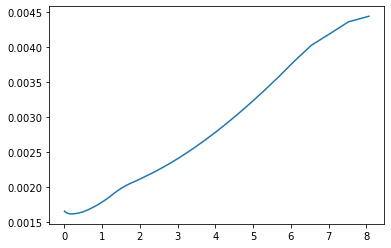

Best Alpha: 0.18636687003259295


,config,alpha
0,returns - SGS adjust_laplacian=True laplacian_...,0.005234
1,returns - Identity - Quantile-std w=2 q=1.0 ga...,0.004695
2,residuals - Corr-50 use_abs=True - Quantile-st...,0.004631
3,returns - Identity - Quantile w=12 q=0.2 both,0.004572
4,residuals - Corr-1 use_abs=True - Quantile-std...,0.004151
5,residuals - Identity - Quantile w=2 q=0.2 both,0.004013
6,residuals - Identity - Quantile w=1 q=0.2 both,0.003918
7,residuals - LGMRF adjust_laplacian=True laplac...,0.003755
8,residuals - LGMRF adjust_laplacian=True laplac...,0.003702
9,residuals - SGS adjust_laplacian=False laplaci...,0.003602


In [179]:
trading_returns_lm = MultiTaskElasticNetCV(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
plt.plot(trading_returns_lm.alphas_, trading_returns_lm.mse_path_.mean(axis=-1))
plt.show()
best_alpha = trading_returns_lm.alphas_[trading_returns_lm.mse_path_.mean(axis=-1).argmin()]
print(f'Best Alpha: {best_alpha}')
trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
pd.Series(2**trading_returns_lm.intercept_ - 1, index=trading_returns.columns, name='alpha').sort_values(ascending=False).reset_index().drop_duplicates('alpha').head(15)

In [155]:
trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
# trading_returns_lm = ElasticNet(alpha = best_alpha, fit_intercept = True).fit(factors.loc[trading_returns.index], trading_returns)
# trading_returns_lm = Lasso(alpha = 0.185, fit_intercept = True).fit(factors.loc[trading_returns.index], trading_returns)
pd.Series(2**trading_returns_lm.intercept_ - 1, index=trading_returns.columns, name='alpha').sort_values(ascending=False).reset_index().drop_duplicates('alpha').head(15)

,config,alpha
0,residuals - Identity - Quantile-std w=2 q=1.0 ...,0.002641
1,residuals - Identity - Quantile w=1 q=0.5 both,0.002448
2,residuals - LGMRF adjust_laplacian=True laplac...,0.002018
3,residuals - Identity - Quantile w=2 q=0.2 both,0.002005
4,residuals - Identity - Quantile w=1 q=0.2 both,0.001957
5,residuals - LGMRF adjust_laplacian=True laplac...,0.001849
6,residuals - LGMRF adjust_laplacian=True laplac...,0.001835
7,residuals - Identity - Quantile w=2 q=0.5 both,0.001767
8,residuals - LGMRF adjust_laplacian=True laplac...,0.001613
9,residuals - Identity - Quantile-std w=12 q=1.0...,0.001581


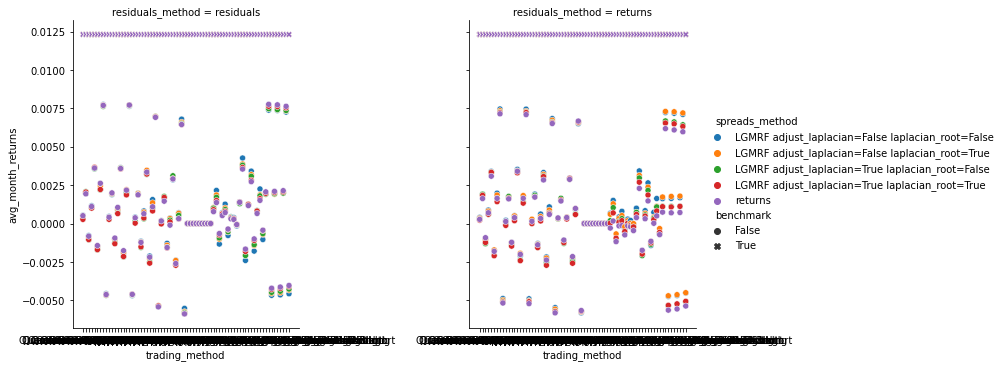

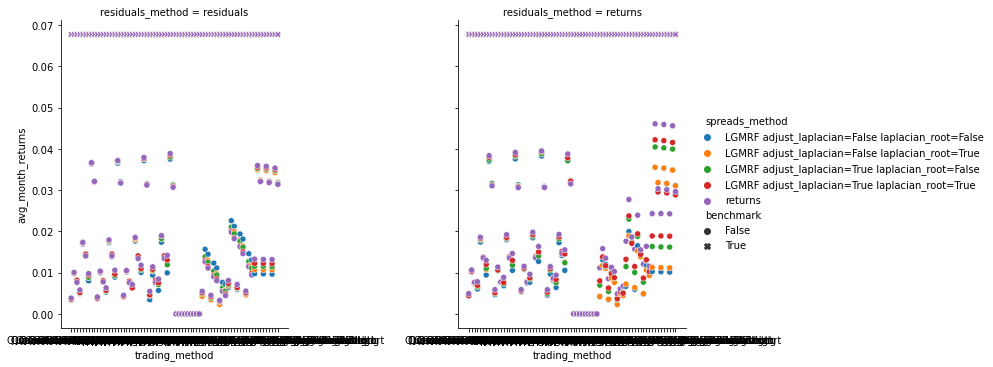

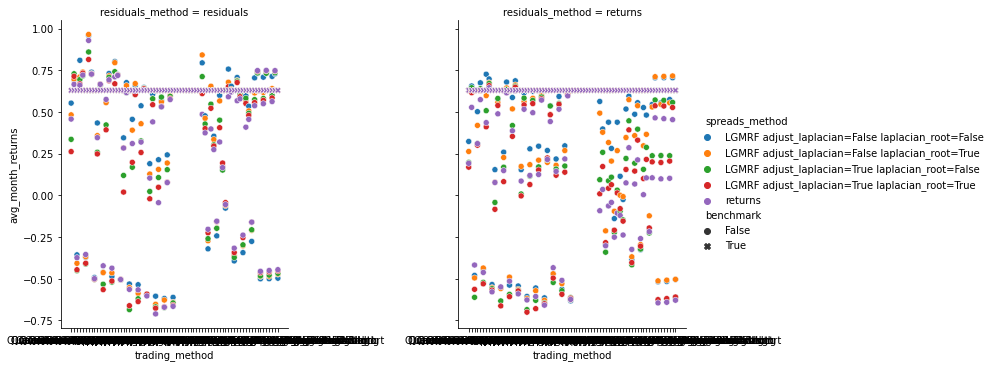

In [254]:
grouped_split_results = split_returns_df.groupby(['trading_method', 'spreads_method', 'residuals_method', 'benchmark'])['avg_month_returns']
# fig, axs = plt.subplots(3, figsize=(16, 15))

sns.relplot(data=(grouped_split_results.mean()).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark', 
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()
sns.relplot(data=(grouped_split_results.std()).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark', 
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()
sns.relplot(data=(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark',
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()

<AxesSubplot:ylabel='config'>

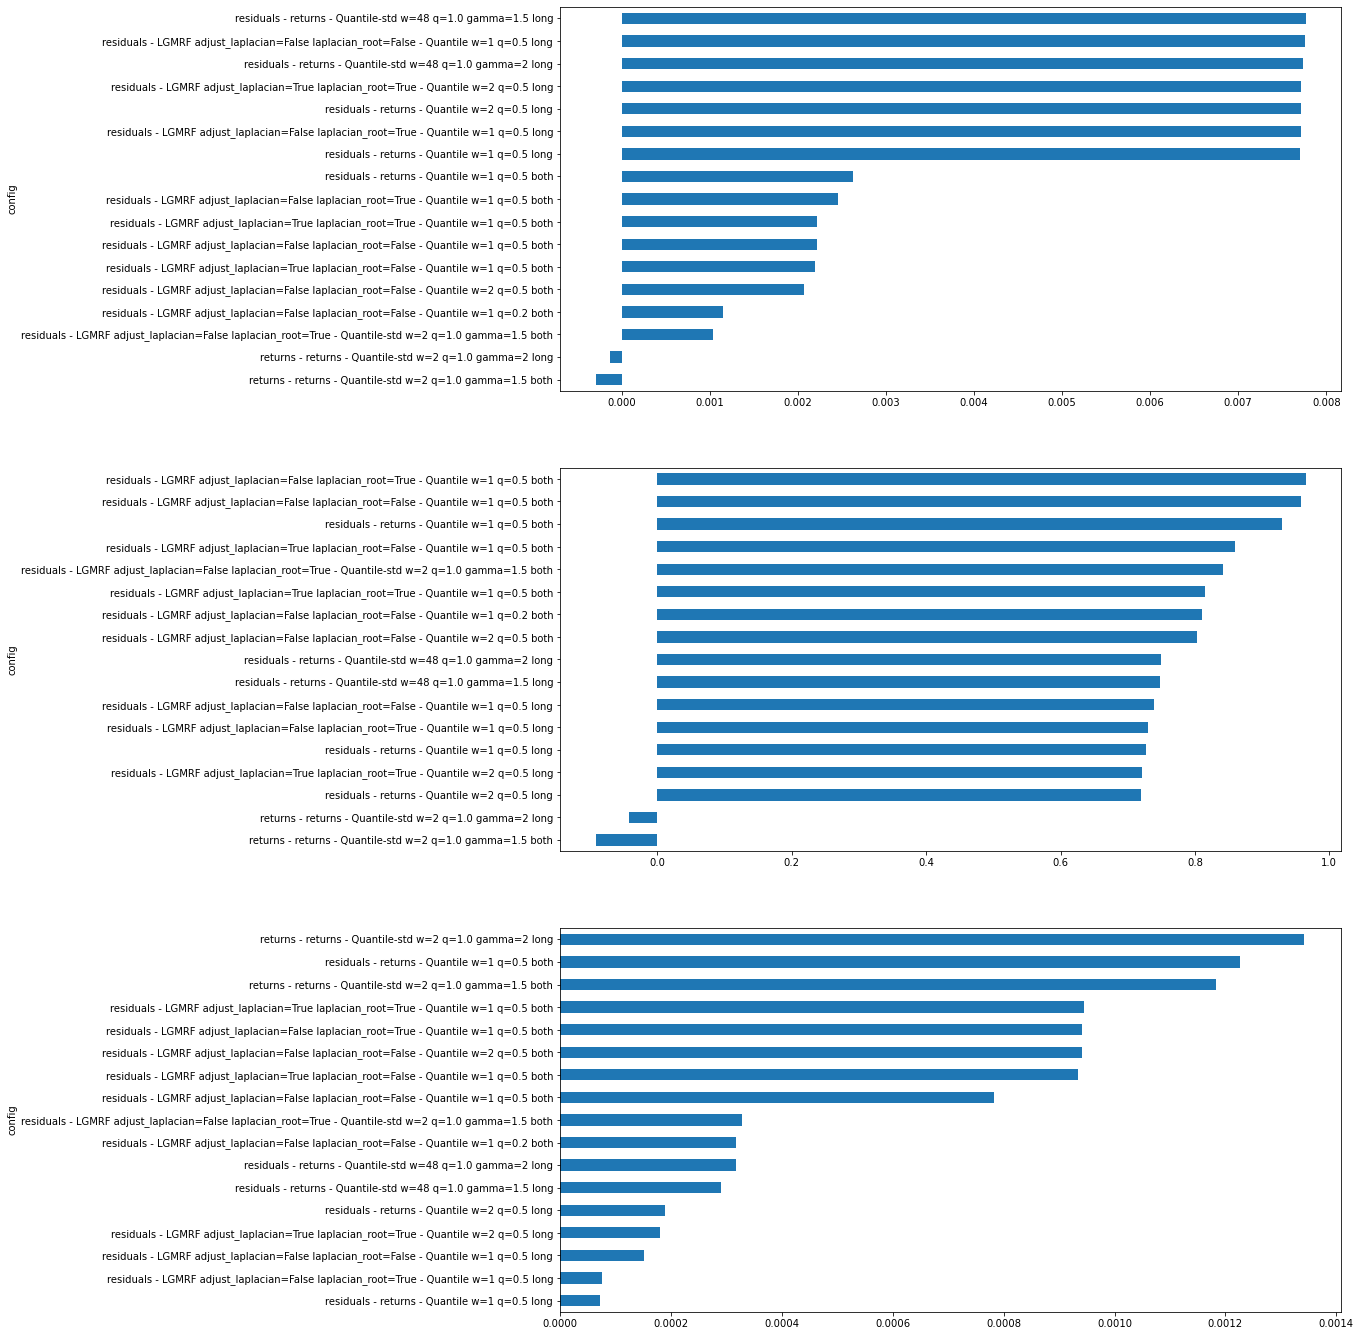

In [255]:
fig, axs = plt.subplots(3, figsize=(14, 24))
grouped_split_results = split_returns_df[split_returns_df['config'].isin(top_configs) & (split_returns_df['benchmark'] == False)].groupby('config')['avg_month_returns']
grouped_split_results.mean().sort_values(ascending=True).plot.barh(x='config', y='avg_month_returns', ax=axs[0])
(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).sort_values(ascending=True).plot.barh(x='config', y='avg_month_returns', ax=axs[1])
trading_alphas[top_configs].sort_values(ascending=True).plot.barh(ax=axs[2])

In [ ]:
split_results_df = pd.concat(split_results_list)
split_results_df['date'] = pd.to_datetime(split_results_df['date'].str[:4] + '-' + split_results_df['date'].str[4:] + '-01')
split_results_df['window'] = split_results_df['w'].astype(str)
split_results_df['quantile'] = split_results_df['q'].astype(str)
split_results_df['index'] += 1
# split_results_df = split_results_df[(split_results_df['w'] != 24).values]
split_results_df

In [ ]:
mean_split_results_df = split_results_df.groupby(['date', 'q', 'w', 'trading_type', 'benchmark'])['avg_month_returns'].mean().reset_index()
clean_split_results_df = []
for i, g in mean_split_results_df.groupby(['q', 'w', 'trading_type', 'benchmark']):
    g = g.sort_values('date')
    g['cumulative_monthly_returns'] = g['avg_month_returns'].cumsum()
    clean_split_results_df.append(g)
clean_split_results_df = pd.concat(clean_split_results_df)
clean_split_results_df

In [ ]:
set(['a', 'a', 'b', 'c', 'b'])

In [ ]:
sns.relplot(data=clean_split_results_df, x='date', y='cumulative_monthly_returns', 
            hue='trading_type', style='benchmark', 
            row='w', col='q', kind='line', height=3, aspect=3)
plt.show()

In [ ]:
sns.relplot(data=clean_split_results_df, x='w', y='avg_month_returns', 
            row='trading_type', col='q', 
            hue='benchmark', kind='line', height=3, aspect=2)
plt.show()

In [ ]:
grouped_split_results = clean_split_results_df.groupby(['q', 'w', 'trading_type', 'benchmark'])['avg_month_returns']
# fig, axs = plt.subplots(3, figsize=(16, 15))

sns.relplot(data=(grouped_split_results.mean()).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()
sns.relplot(data=(grouped_split_results.std()).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()
sns.relplot(data=(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()

In [ ]:
# %%time
# train_spreads, test_spreads, L, L_sqrt = compute_spreads(train_residuals, test_residuals, laplacian_root=False, reltol=2.5e-4)
# pd.DataFrame({'train': np.abs(np.sign(train_spreads.cumsum()).diff() / 2).sum().round(), 
#               'test': np.abs(np.sign(test_spreads.cumsum()).diff() / 2).sum().round()}).plot.hist(bins=40, alpha=.4)
# pd.DataFrame({'train': np.abs(np.sign(train_spreads.cumsum()).diff() / 2).sum().round(), 
#               'test': np.abs(np.sign(test_spreads.cumsum()).diff() / 2).sum().round()}).mean()